In [1]:
import os
import sys
from os import listdir
from os.path import isfile, join
import IPython.display as ipd
import librosa 
import librosa.display
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wav
import numpy as np
from timeit import default_timer as timer
%run utils.ipynb #All the common and important functions are imported from this file 

## Implementation on the Closed Set
1. Make a dataframe and only take the audio files from the <font color=Red>**Timit Dataset**</font>.
1. Here we extract the MFCC feature spectrogram from the raw audio using the sample rate of <font color=Red>22050Hz</font>.
1. The Timit dataset comprises of 4620 samples and using the normal convention we divide the dataset into a ratio of 80:20 where 80% of data is used to train the model and the rest is used to test the model.
1. A Convolutional Neural Network model is built which consist of 2 convolutional layers each accompanied by a Max pooling layer. The weights are normalised using BatchNormalization to tackle the problems of covariate shift. Following the BatchNormalization layer are 2 dense layers where dropout regularization is used to avoid the problems of overfitting. Finally we have a softmax layer for the predicting the probability of certain classes. 
| Model | Total Trainable Parameter | Training Acc | Valdiation Acc |
|:-:|:-:|:-:|:-:|
| CNN | 608,718 | 99 | 84 |
| LSTM | 608, 718 | 99 | 72 |

- **Using the same the number of trainable parameters CNN works better than LSTM on the closed set problem**

In [2]:
filename = "H:/Timit/data/TRAIN/DR1/FCJF0/SA1.WAV.wav"

In [3]:
ipd.Audio(filename)

[ 1.68822735e-05 -2.13854419e-05  1.19674605e-05  5.80409724e-05
  9.45295687e-06 -2.22698181e-05  4.74363551e-05  7.65636141e-05
  2.52885820e-05  1.34728016e-05]
(20, 126)
Audio (64493,)
Sample_rate 22050
[[-714.2773    -720.08246   -698.1377    ... -585.2545    -607.69055
  -632.26746  ]
 [  39.838463    34.951435    55.14386   ...   71.52338     64.15399
    60.767807 ]
 [   6.531245     7.0113783    3.7127492 ...  -73.011566   -63.395973
   -49.707542 ]
 ...
 [  -7.9823294   -4.883434     4.432587  ...  -15.210547   -13.460598
    -8.583052 ]
 [   2.4719388    2.5721161    6.817891  ...   11.8894825   18.972626
    18.225517 ]
 [   4.6764083    5.1303983    4.949523  ...    4.4585204    7.749157
     5.796713 ]]


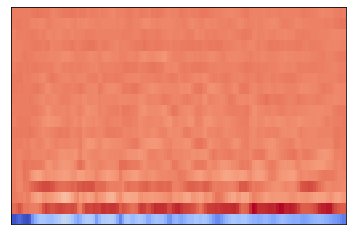

In [4]:
audio, sample_rate= librosa.load(filename, res_type="kaiser_fast" )
print(audio[:10])
mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, hop_length=512)
print(mfccs.shape)
librosa.display.specshow(mfccs)
print("Audio", audio.shape)
print("Sample_rate", sample_rate)
print(mfccs)

In [5]:
extract_MFCC(filename).shape

(100,)

In [6]:
file2 = "H:/Timit/data/TRAIN/DR4/MMDM0/SI1311.PHN" #not a audio file

In [7]:
ipd.Audio(file2)

In [8]:
timit_df = pd.read_csv("H:/Timit/train_data.csv")
timit_df.head()

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_phonetic_file,is_sentence_file
0,1.0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False,False
1,2.0,TRAIN,DR4,MMDM0,SI1311.PHN,TRAIN/DR4/MMDM0/SI1311.PHN,TRAIN\\DR4\\MMDM0\\SI1311.PHN,False,False,False,True,False
2,3.0,TRAIN,DR4,MMDM0,SI1311.WRD,TRAIN/DR4/MMDM0/SI1311.WRD,TRAIN\\DR4\\MMDM0\\SI1311.WRD,False,False,True,False,False
3,4.0,TRAIN,DR4,MMDM0,SX321.PHN,TRAIN/DR4/MMDM0/SX321.PHN,TRAIN\\DR4\\MMDM0\\SX321.PHN,False,False,False,True,False
4,5.0,TRAIN,DR4,MMDM0,SX321.WRD,TRAIN/DR4/MMDM0/SX321.WRD,TRAIN\\DR4\\MMDM0\\SX321.WRD,False,False,True,False,False


In [9]:
timit_df.drop("is_phonetic_file", axis=1, inplace=True)

In [10]:
timit_df.shape

(31678, 11)

In [11]:
timit_df.isnull().sum()

index                         8578
test_or_train                 8578
dialect_region                8578
speaker_id                    8578
filename                      8578
path_from_data_dir            8578
path_from_data_dir_windows    8578
is_converted_audio            8578
is_audio                      8578
is_word_file                  8578
is_sentence_file              8578
dtype: int64

In [12]:
timit_df=timit_df.dropna()

In [13]:
timitAudio_df=timit_df[timit_df["filename"].str.contains(".wav")]

In [14]:
print(timitAudio_df.shape)

(4620, 11)


In [15]:
timitAudio_df.head()

,index,test_or_train,dialect_region,speaker_id,filename,path_from_data_dir,path_from_data_dir_windows,is_converted_audio,is_audio,is_word_file,is_sentence_file
0,1.0,TRAIN,DR4,MMDM0,SI681.WAV.wav,TRAIN/DR4/MMDM0/SI681.WAV.wav,TRAIN\\DR4\\MMDM0\\SI681.WAV.wav,True,True,False,False
6,7.0,TRAIN,DR4,MMDM0,SI1311.WAV.wav,TRAIN/DR4/MMDM0/SI1311.WAV.wav,TRAIN\\DR4\\MMDM0\\SI1311.WAV.wav,True,True,False,False
10,11.0,TRAIN,DR4,MMDM0,SX141.WAV.wav,TRAIN/DR4/MMDM0/SX141.WAV.wav,TRAIN\\DR4\\MMDM0\\SX141.WAV.wav,True,True,False,False
13,14.0,TRAIN,DR4,MMDM0,SX51.WAV.wav,TRAIN/DR4/MMDM0/SX51.WAV.wav,TRAIN\\DR4\\MMDM0\\SX51.WAV.wav,True,True,False,False
23,24.0,TRAIN,DR4,MMDM0,SX411.WAV.wav,TRAIN/DR4/MMDM0/SX411.WAV.wav,TRAIN\\DR4\\MMDM0\\SX411.WAV.wav,True,True,False,False


In [16]:
timitAudio_df.iloc[2].path_from_data_dir

'TRAIN/DR4/MMDM0/SX141.WAV.wav'

In [17]:
timitAudio_df.iloc[2].speaker_id

'MMDM0'

In [18]:
mfcc= extract_MFCC("H:/Timit/data/TRAIN/DR4/MLEL0/SI616.WAV.wav")
print(mfcc.shape)
ipd.Audio("H:/Timit/data/TRAIN/DR4/MLEL0/SI616.WAV.wav")

(100,)


In [19]:
mfcc_features = []
exceptions=0

start_time = timer()
for i in range(4620):
    # get file path
    filepath = "H:/Timit/data/" +timitAudio_df.iloc[i].path_from_data_dir
    try: # extract features
        mfccs = extract_MFCC(filepath)
        features=np.reshape((mfccs),(20,5))
            
    except: # else exception (.ds_store files are part of mac file systems)
        print(filepath)
        exceptions += 1
        continue
    if i%500==0:
        print("Finished extracting Mfcc from 500 files")
            
    label = timitAudio_df.iloc[i].speaker_id
    mfcc_features.append([features, features.shape, label])
        
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Exceptions:  0
time taken: 3.0 minutes 54.6 seconds
None
Finished feature extraction from all folder


In [20]:
cols=['MFCC_Features', 'Matrix_Shape', 'Label']
preprocessed_pd=pd.DataFrame(data=mfcc_features , columns=cols)
preprocessed_pd.head()

,MFCC_Features,Matrix_Shape,Label
0,"[[-508.89304, 111.33905, -46.41684, 57.94378, ...","(20, 5)",MMDM0
1,"[[-515.4079, 117.165016, -45.93223, 44.849792,...","(20, 5)",MMDM0
2,"[[-518.1341, 113.458, -43.350677, 47.879726, -...","(20, 5)",MMDM0
3,"[[-525.56433, 114.15054, -39.9983, 39.491375, ...","(20, 5)",MMDM0
4,"[[-519.8656, 118.94035, -45.174545, 37.606926,...","(20, 5)",MMDM0


In [21]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

X= np.array(preprocessed_pd.MFCC_Features.tolist())

In [22]:
le=LabelEncoder()
y= to_categorical(le.fit_transform(preprocessed_pd.Label))

In [23]:
print(X.shape)
print(y.shape)

(4620, 20, 5)
(4620, 462)


In [24]:
X= np.reshape(X, (4620,20, 5, 1))

In [25]:
X.shape

(4620, 20, 5, 1)

In [26]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [27]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(3696, 20, 5, 1) (3696, 462) (924, 20, 5, 1) (924, 462)


In [28]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics

In [34]:
model=Sequential()
model.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,5,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))
model.add(Dropout(0.3))
 
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())


model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(462,activation="softmax"))

In [35]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 2, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 2, 128)         512       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)              

In [36]:
import tensorflow as tf 
 
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") > 0.82:
            print("\n Reached the desired accuracy so stopped training")
            self.model.stop_training =True

In [37]:
mycallback = myCallback()

In [38]:
start_time=timer()
history=model.fit(x_train,y_train,batch_size=50,epochs=500, validation_data=(x_test, y_test), callbacks=[mycallback])
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Epoch 1/500
74/74 [==============================] - 7s 99ms/step - loss: 6.1682 - accuracy: 8.1169e-04 - val_loss: 6.1367 - val_accuracy: 0.0022
Epoch 2/500
74/74 [==============================] - 5s 73ms/step - loss: 6.1427 - accuracy: 0.0030 - val_loss: 6.1206 - val_accuracy: 0.0022
Epoch 3/500
74/74 [==============================] - 5s 74ms/step - loss: 6.1054 - accuracy: 0.0019 - val_loss: 6.0631 - val_accuracy: 0.0054
Epoch 4/500
74/74 [==============================] - 5s 74ms/step - loss: 5.8416 - accuracy: 0.0065 - val_loss: 5.4925 - val_accuracy: 0.0141
Epoch 5/500
74/74 [==============================] - 5s 74ms/step - loss: 5.4108 - accuracy: 0.0084 - val_loss: 5.1817 - val_accuracy: 0.0206
Epoch 6/500
74/74 [==============================] - 5s 74ms/step - loss: 5.1088 - accuracy: 0.0168 - val_loss: 5.0051 - val_accuracy: 0.0249
Epoch 7/500
74/74 [==============================] - 5s 74ms/step - loss: 4.8550 - accuracy: 0.0211 - val_loss: 5.0228 - val_accuracy: 0.0292
Ep

In [39]:
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100)

test_score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", test_score[1]*100)

Training Accuracy:  100.0
Testing Accuracy:  80.62770366668701


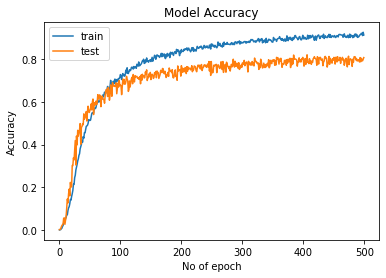

In [41]:
#plot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No of epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test) , axis=1)

## Building an LSTM model for the Timit Dataset

In [63]:
# Building an LSTM model for classification
from keras.layers import LSTM, TimeDistributed, GlobalAveragePooling1D
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences =True, input_shape=(20,5)))
model_lstm.add(LSTM(128, return_sequences =True, dropout=0.3))

model_lstm.add(BatchNormalization())
model_lstm.add(TimeDistributed(Dense(256, activation='relu')))
model_lstm.add(Dropout(0.5))
model_lstm.add(TimeDistributed(Dense(512, activation='relu')))
model_lstm.add(Dropout(0.5))
model_lstm.add(GlobalAveragePooling1D())
model_lstm.add(Dense(462, activation='softmax'))

In [64]:
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20, 128)           68608     
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 128)           512       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 20, 256)           33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 20, 512)           131584    
_________________________________________________________________
dropout_11 (Dropout)         (None, 20, 512)          

In [65]:
model_lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [66]:
x_train = np.squeeze(x_train)
x_test = np.squeeze(x_test)
print(x_train.shape)

In [67]:
start_time=timer()
history=model_lstm.fit(x_train,y_train,batch_size=50,epochs=500, validation_data=(x_test, y_test))
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Epoch 1/500
74/74 [==============================] - 14s 187ms/step - loss: 6.0625 - accuracy: 0.0062 - val_loss: 5.9281 - val_accuracy: 0.0162
Epoch 2/500
74/74 [==============================] - 10s 131ms/step - loss: 4.8224 - accuracy: 0.0300 - val_loss: 4.9784 - val_accuracy: 0.0584
Epoch 3/500
74/74 [==============================] - 10s 136ms/step - loss: 3.9996 - accuracy: 0.0909 - val_loss: 4.1922 - val_accuracy: 0.1374
Epoch 4/500
74/74 [==============================] - 10s 131ms/step - loss: 3.3427 - accuracy: 0.1726 - val_loss: 3.6178 - val_accuracy: 0.1851
Epoch 5/500
74/74 [==============================] - 10s 131ms/step - loss: 2.7277 - accuracy: 0.2652 - val_loss: 2.8206 - val_accuracy: 0.3041
Epoch 6/500
74/74 [==============================] - 10s 135ms/step - loss: 2.2688 - accuracy: 0.3623 - val_loss: 2.4221 - val_accuracy: 0.3593
Epoch 7/500
74/74 [==============================] - 10s 136ms/step - loss: 1.9620 - accuracy: 0.4291 - val_loss: 2.3094 - val_accuracy:

In [68]:
score = model_lstm.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1]*100)

test_score = model_lstm.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", test_score[1]*100)

Training Accuracy:  99.83766078948975
Testing Accuracy:  71.53679728507996


### Implementation on the Open Set
1. Firstly, we extract the features from the training samples of <font color=red>4620</font> which contains of <font color=red>462</font> speaker classes.
1. Secondly, we train the model using the extracted MFCC spectra features. 
1. When the model has learned the features and have optimised weights after several epochs, we built a another intermediate model by poping out the last softmax layer. 
1. Then, we extract the MFCC spectra features from the testing samples of <font color=red>1680</font> which contains <font color=red>168</font> speaker classes.
1. Finally, the intermediate model is used to ouput an embedding vector for a test sample and it is used to match the nine most similar sample using cosine similarity, euclidian distance and manhattan distance. Then the labels are match to find out the accuracy of the model. 

| Models | Total trainable parameters | Training Acc | Testing Acc | Similarities used |
|:-:|:-:|:-:|:-:|:-:|
| CNN | 608,462 | 93% | 78% | cosine |
| LSTM | 602,062 | 97% | 62% | cosine |


In [75]:
timit_1 = pd.read_csv("H:/timit/train_data.csv")

In [76]:
timit_1.drop("is_phonetic_file", axis=1, inplace=True)

In [77]:
timit_1.dropna(inplace=True)

In [78]:
#keeping only the audio files 
timit_1 = timit_1[timit_1["filename"].str.contains(".wav")]

In [79]:
timit_1.shape

(4620, 11)

In [80]:
train_features = []
exceptions=0

start_time = timer()
for i in range(4620):
    # get file path
    filepath = "H:/Timit/data/" +timit_1.iloc[i].path_from_data_dir
    try: # extract features
        mfccs = extract_MFCC(filepath)
        features=np.reshape((mfccs),(20,5))
            
    except: # else exception (.ds_store files are part of mac file systems)
        print(filepath)
        exceptions += 1
        continue
    if i%500==0:
        print("Finished extracting Mfcc from 500 files")
            
    label = timit_1.iloc[i].speaker_id
    train_features.append([features, features.shape, label])
        
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Exceptions:  0
time taken: 5.0 minutes 15.5 seconds
None
Finished feature extraction from all folder


In [81]:
cols = ["features", "shape", "label"]
features_df = pd.DataFrame(data= train_features, columns = cols)

In [82]:
features_df.head()

,features,shape,label
0,"[[-508.89304, 111.33905, -46.41684, 57.94378, ...","(20, 5)",MMDM0
1,"[[-515.4079, 117.165016, -45.93223, 44.849792,...","(20, 5)",MMDM0
2,"[[-518.1341, 113.458, -43.350677, 47.879726, -...","(20, 5)",MMDM0
3,"[[-525.56433, 114.15054, -39.9983, 39.491375, ...","(20, 5)",MMDM0
4,"[[-519.8656, 118.94035, -45.174545, 37.606926,...","(20, 5)",MMDM0


In [83]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
encoder = LabelEncoder()
y_train=to_categorical(encoder.fit_transform(features_df["label"]) )
y_train.shape

(4620, 462)

In [84]:
x_train=np.reshape(np.array(features_df["features"].tolist()), (4620, 20, 5,1) )
x_train.shape

(4620, 20, 5, 1)

In [85]:
#building the model with softmax loss
model_open=Sequential()
model_open.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(20,5,1)))
model_open.add(MaxPooling2D(padding="same"))

model_open.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_open.add(MaxPooling2D(padding="same"))
model_open.add(Dropout(0.3))
 
model_open.add(BatchNormalization())

model_open.add(GlobalAveragePooling2D())


model_open.add(Dense(256,activation="relu"))
model_open.add(Dropout(0.5))

model_open.add(Dense(512,activation="relu"))
model_open.add(Dropout(0.5))

model_open.add(Dense(462,activation="softmax"))

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 20, 5, 64)         1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 3, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 3, 128)        204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 2, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 2, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 2, 128)         512       
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)              

In [87]:
model_open.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [90]:
history = model_open.fit(x_train, y_train, epochs=300, batch_size=50)

Epoch 1/300
93/93 [==============================] - 9s 96ms/step - loss: 0.5135 - accuracy: 0.8331
Epoch 2/300
93/93 [==============================] - 7s 72ms/step - loss: 0.5425 - accuracy: 0.8253
Epoch 3/300
93/93 [==============================] - 7s 70ms/step - loss: 0.5081 - accuracy: 0.8364
Epoch 4/300
93/93 [==============================] - 7s 72ms/step - loss: 0.5202 - accuracy: 0.8361
Epoch 5/300
93/93 [==============================] - 7s 71ms/step - loss: 0.5269 - accuracy: 0.8394
Epoch 6/300
93/93 [==============================] - 7s 71ms/step - loss: 0.5094 - accuracy: 0.8320
Epoch 7/300
93/93 [==============================] - 7s 71ms/step - loss: 0.5353 - accuracy: 0.8273
Epoch 8/300
93/93 [==============================] - 7s 76ms/step - loss: 0.4631 - accuracy: 0.8556
Epoch 9/300
93/93 [==============================] - 7s 76ms/step - loss: 0.5291 - accuracy: 0.8329
Epoch 10/300
93/93 [==============================] - 7s 72ms/step - loss: 0.5454 - accuracy: 0.8262

#### Building an intermediate model 

In [91]:
model_open.layers[-1].output

<tf.Tensor 'dense_17/Softmax:0' shape=(None, 462) dtype=float32>

In [92]:
import tensorflow as tf

In [94]:
#building an itermediate model 
from keras.models import Model
intermediate_open_model = Model(inputs= model_open.input, outputs= model_open.layers[-2].output) 

#### Extractng the features from the testing data

In [102]:
test_data_timit = pd.read_csv("H:/timit/test_data.csv")

In [103]:
test_data_timit.dropna(inplace=True)

In [104]:
test_data_timit = test_data_timit[test_data_timit["filename"].str.contains(".wav")]

In [105]:
test_data_timit.shape

(1680, 12)

In [106]:
test_timit_features = []
exceptions=0

start_time = timer()
for i in range(1680):
    # get file path
    filepath = "H:/Timit/data/" +test_data_timit.iloc[i].path_from_data_dir
    try: # extract features
        mfccs = extract_MFCC(filepath)
        features=np.reshape((mfccs),(20,5)) 
            
    except: # else exception (.ds_store files are part of mac file systems)
        print(filepath)
        exceptions += 1
        continue
    if i%500==0:
        print("Finished extracting Mfcc from 500 files")
            
    label = test_data_timit.iloc[i].speaker_id
    test_timit_features.append([features, features.shape, label])
        
            #print(f,old_samplerate,ss)
        
print("Exceptions: ", exceptions)
end_time = timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))
print('Finished feature extraction from all folder')

Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Finished extracting Mfcc from 500 files
Exceptions:  0
time taken: 1.0 minutes 48.4 seconds
None
Finished feature extraction from all folder


In [107]:
cols = ["features", "shape", "label"]
features_df = pd.DataFrame(data= test_timit_features, columns = cols)
features_df.head()

,features,shape,label
0,"[[-467.30576, 116.68951, -40.94005, 33.351284,...","(20, 5)",MGMM0
1,"[[-457.5769, 121.477264, -46.502857, 26.054605...","(20, 5)",MGMM0
2,"[[-515.81433, 111.14143, -41.46303, 23.258158,...","(20, 5)",MGMM0
3,"[[-479.12405, 100.9241, -59.813065, 56.59974, ...","(20, 5)",MGMM0
4,"[[-481.05725, 95.59378, -51.556053, 22.493881,...","(20, 5)",MGMM0


In [108]:
x_test_timit = np.reshape(np.array(features_df["features"].tolist()), (1680, 20, 5, 1) )
encod = LabelEncoder()
y_test_timit = to_categorical(encod.fit_transform(features_df["label"]))
y_test_timit.shape

(1680, 168)

In [109]:
x_test_timit.shape

(1680, 20, 5, 1)

In [110]:
predictions=intermediate_model.predict(x_test_timit)

In [41]:
predictions /= np.linalg.norm(predictions, axis=1, keepdims=True)

In [114]:
from scipy import spatial

In [140]:
%run utils.ipynb

In [141]:
acc_CNN_open = calculate_accuracy(x_test_timit, y_test_timit, intermediate_open_model)

Calculating the 0 th sample
[(0.7891664505004883, 91, 91), (0.6674177646636963, 91, 123), (0.6672788858413696, 91, 91), (0.6624776721000671, 91, 81), (0.6399805545806885, 91, 134), (0.6141633987426758, 91, 104), (0.6084476709365845, 91, 151), (0.6045756936073303, 91, 91), (0.5996782779693604, 91, 91)]
Calculating the 1 th sample
[(0.7498615980148315, 161, 153), (0.7443316578865051, 161, 161), (0.7336809039115906, 161, 153), (0.7182449698448181, 161, 91), (0.7181976437568665, 161, 153), (0.7096335887908936, 161, 124), (0.6864168047904968, 161, 155), (0.6822864413261414, 161, 113), (0.6811754107475281, 161, 153)]
Calculating the 2 th sample
[(0.8304588794708252, 45, 45), (0.8085200786590576, 45, 45), (0.785487174987793, 45, 45), (0.7811880707740784, 45, 4), (0.7779436111450195, 45, 45), (0.7754192352294922, 45, 45), (0.7663581371307373, 45, 45), (0.7212624549865723, 45, 26), (0.718311071395874, 45, 4)]
Calculating the 3 th sample
[(0.744141697883606, 50, 50), (0.7026702165603638, 50, 50)

In [142]:
print("The accuracy of the open set timit in CNN  {:.2f}".format(acc_CNN_open) )

The accuracy of the open set timit in CNN  77.51


In [143]:
print("The shapes of the matrix :")
print("Xtrain shape :{} \nYtrain shape :{} \nXtest shape :{} \nYtest shape :{}".format(x_train.shape, y_train.shape, x_test_timit.shape, y_test_timit.shape) )

The shapes of the matrix :
Xtrain shape :(4620, 20, 5, 1) 
Ytrain shape :(4620, 462) 
Xtest shape :(1680, 20, 5, 1) 
Ytest shape :(1680, 168)


In [144]:
x_train_lstm=np.squeeze(x_train)
x_test_lstm = np.squeeze(x_test_timit)

In [145]:
# Building an LSTM model for classification
from keras.layers import LSTM, TimeDistributed, GlobalAveragePooling1D
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences =True, input_shape=(20,5)))
model_lstm.add(LSTM(128, return_sequences =True, dropout=0.3))

model_lstm.add(BatchNormalization())
model_lstm.add(TimeDistributed(Dense(256, activation='relu')))
model_lstm.add(Dropout(0.5))
model_lstm.add(TimeDistributed(Dense(512, activation='relu')))
model_lstm.add(Dropout(0.5))
model_lstm.add(GlobalAveragePooling1D())
model_lstm.add(Dense(462, activation='softmax'))

In [146]:
model_lstm.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 20, 128)           68608     
_________________________________________________________________
lstm_7 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
batch_normalization_5 (Batch (None, 20, 128)           512       
_________________________________________________________________
time_distributed_6 (TimeDist (None, 20, 256)           33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 256)           0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 20, 512)           131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 512)          

In [147]:
start_time=timer()
model_lstm.fit(x_train_lstm,y_train,batch_size=30,epochs=100)
end_time=timer()
print(print("time taken: {0} minutes {1:.1f} seconds".format((end_time - start_time)//60, (end_time - start_time)%60)))

Epoch 1/100
154/154 [==============================] - 21s 137ms/step - loss: 5.9132 - accuracy: 0.0037
Epoch 2/100
154/154 [==============================] - 21s 139ms/step - loss: 4.4985 - accuracy: 0.0502
Epoch 3/100
154/154 [==============================] - 22s 140ms/step - loss: 3.7056 - accuracy: 0.1097
Epoch 4/100
154/154 [==============================] - 21s 138ms/step - loss: 3.0886 - accuracy: 0.2030
Epoch 5/100
154/154 [==============================] - 22s 142ms/step - loss: 2.5685 - accuracy: 0.2961
Epoch 6/100
154/154 [==============================] - 24s 159ms/step - loss: 2.1491 - accuracy: 0.3942
Epoch 7/100
154/154 [==============================] - 23s 148ms/step - loss: 1.7952 - accuracy: 0.4738
Epoch 8/100
154/154 [==============================] - 21s 139ms/step - loss: 1.4945 - accuracy: 0.5580
Epoch 9/100
154/154 [==============================] - 22s 140ms/step - loss: 1.2873 - accuracy: 0.6121
Epoch 10/100
154/154 [==============================] - 21s 140m

In [153]:
#building an intermediate LSTM model
intermediate_lstm_model= Model(inputs= model_lstm.input, outputs= model_lstm.layers[-2].output) 

In [154]:
predictions=intermediate_lstm_model.predict(x_test_lstm)

In [150]:
print(predictions[0].shape)

(512,)


In [156]:
acc_lstm  = calculate_accuracy(x_test_lstm, y_test_timit, intermediate_lstm_model)

Calculating the 0 th sample
[(0.7242638468742371, 91, 91), (0.7062529921531677, 91, 91), (0.6633365154266357, 91, 145), (0.6261966228485107, 91, 120), (0.6142433881759644, 91, 77), (0.613495945930481, 91, 61), (0.6077526807785034, 91, 77), (0.6032646894454956, 91, 161), (0.5957689881324768, 91, 140)]
Calculating the 1 th sample
[(0.8045823574066162, 161, 161), (0.7201691269874573, 161, 161), (0.7022906541824341, 161, 153), (0.6983113288879395, 161, 161), (0.691741406917572, 161, 161), (0.6751044392585754, 161, 153), (0.6474509239196777, 161, 153), (0.6426753997802734, 161, 161), (0.6419625282287598, 161, 122)]
Calculating the 2 th sample
[(0.8730790615081787, 45, 45), (0.8576285243034363, 45, 45), (0.8153852820396423, 45, 45), (0.7915809750556946, 45, 45), (0.7857063412666321, 45, 31), (0.7840904593467712, 45, 45), (0.7690478563308716, 45, 49), (0.751253068447113, 45, 49), (0.728977620601654, 45, 77)]
Calculating the 3 th sample
[(0.7199079990386963, 50, 50), (0.6680740118026733, 50, 5

In [157]:
 print("The Accuracy reached by LSTM on open set {}".format(acc_lstm) )

The Accuracy reached by LSTM on open set 62.133333333333304
